In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, zoo)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 15, repr.plot.height=12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "zoo"        TRUE  


# NYT county level time series 

In [2]:
#%% check timestamp at https://github.com/nytimes/covid-19-data
df = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df[, d := anydate(date)]

In [3]:
df[, cfr := deaths/cases]

In [4]:
setorder(df, state, county, date)
df[order(-date, -cases)][1:20]

date       county        state         fips  cases  deaths d         
1  2020-04-18 New York City New York         NA 131273 8632   2020-04-18
2  2020-04-18 Nassau        New York      36059  29180 1356   2020-04-18
3  2020-04-18 Suffolk       New York      36103  26143  706   2020-04-18
4  2020-04-18 Westchester   New York      36119  23179  738   2020-04-18
5  2020-04-18 Cook          Illinois      17031  20395  860   2020-04-18
6  2020-04-18 Wayne         Michigan      26163  13471 1070   2020-04-18
7  2020-04-18 Bergen        New Jersey    34003  12163  741   2020-04-18
8  2020-04-18 Los Angeles   California     6037  12021  576   2020-04-18
9  2020-04-18 Hudson        New Jersey    34017   9956  434   2020-04-18
10 2020-04-18 Essex         New Jersey    34013   9901  732   2020-04-18
11 2020-04-18 Rockland      New York      36087   9171  234   2020-04-18
12 2020-04-18 Miami-Dade    Florida       12086   9044  198   2020-04-18
13 2020-04-18 Philadelphia  Pennsylvania  42101   9014  342   2020-04-18
14 2020-04-18 Union         New Jersey    34039   8959  356   2020-04-18
15 2020-04-18 Middlesex     Massachusetts 25017   8297  334   2020-04-18
16 2020-04-18 Passaic       New Jersey    34031   7936  243   2020-04-18
17 2020-04-18 Suffolk       Massachusetts 25025   7696  156   2020-04-18
18 2020-04-18 Middlesex     New Jersey    34023   7624  313   2020-04-18
19 2020-04-18 Fairfield     Connecticut    9001   7363  432   2020-04-18
20 2020-04-18 Orange        New York      36071   6281  144   2020-04-18
   cfr    
1  0.06576
2  0.04647
3  0.02701
4  0.03184
5  0.04217
6  0.07943
7  0.06092
8  0.04792
9  0.04359
10 0.07393
11 0.02552
12 0.02189
13 0.03794
14 0.03974
15 0.04026
16 0.03062
17 0.02027
18 0.04105
19 0.05867
20 0.02293

In [5]:
df[,  `:=`(
  new_cases  = cases - shift(cases),
  new_deaths = deaths - shift(deaths)
), by = .(state, county)]
df = df[d >= "2020-03-01"]
rawvars = c("cases", "deaths", "new_cases", "new_deaths")

In [6]:
rollmeaneR = function(df, 
                      smoothvars = rawvars,
                      grouping = c("state", "county"),
                      sm_k = 3){
    f = copy(df)
    setorderv(f, cols = c(grouping, 'd'))
    f[, paste0("rm", sm_k, "_", smoothvars) := lapply(.SD, rollmean, k = sm_k, fill = NA, na.pad = T), 
       by = grouping, .SDcols = smoothvars]
    return(f)
}

# Nationwide 

In [7]:
npan = df[, lapply(.SD, sum, na.rm = T), by = .(d), .SDcols = rawvars]
npan[order(-d)][1:15]

d          cases  deaths new_cases new_deaths
1  2020-04-18 728047 34723  28171     1838      
2  2020-04-17 699860 32885  29217     1369      
3  2020-04-16 668543 30786  31642     2203      
4  2020-04-15 636877 28585  29600     2433      
5  2020-04-14 607263 26081  26354     2467      
6  2020-04-13 580894 23608  25533     1554      
7  2020-04-12 555330 22057  26902     1475      
8  2020-04-11 528414 20578  31471     1860      
9  2020-04-10 496906 18719  33185     2024      
10 2020-04-09 463689 16685  34306     1865      
11 2020-04-08 429280 14779  31467     1851      
12 2020-04-07 397746 12960  33519     2001      
13 2020-04-06 366351 11708  29240     2052      
14 2020-04-05 336407  9660  25520     1155      
15 2020-04-04 310842  8505  34437     1368

Warning message:
“Transformation introduced infinite values in continuous y-axis”


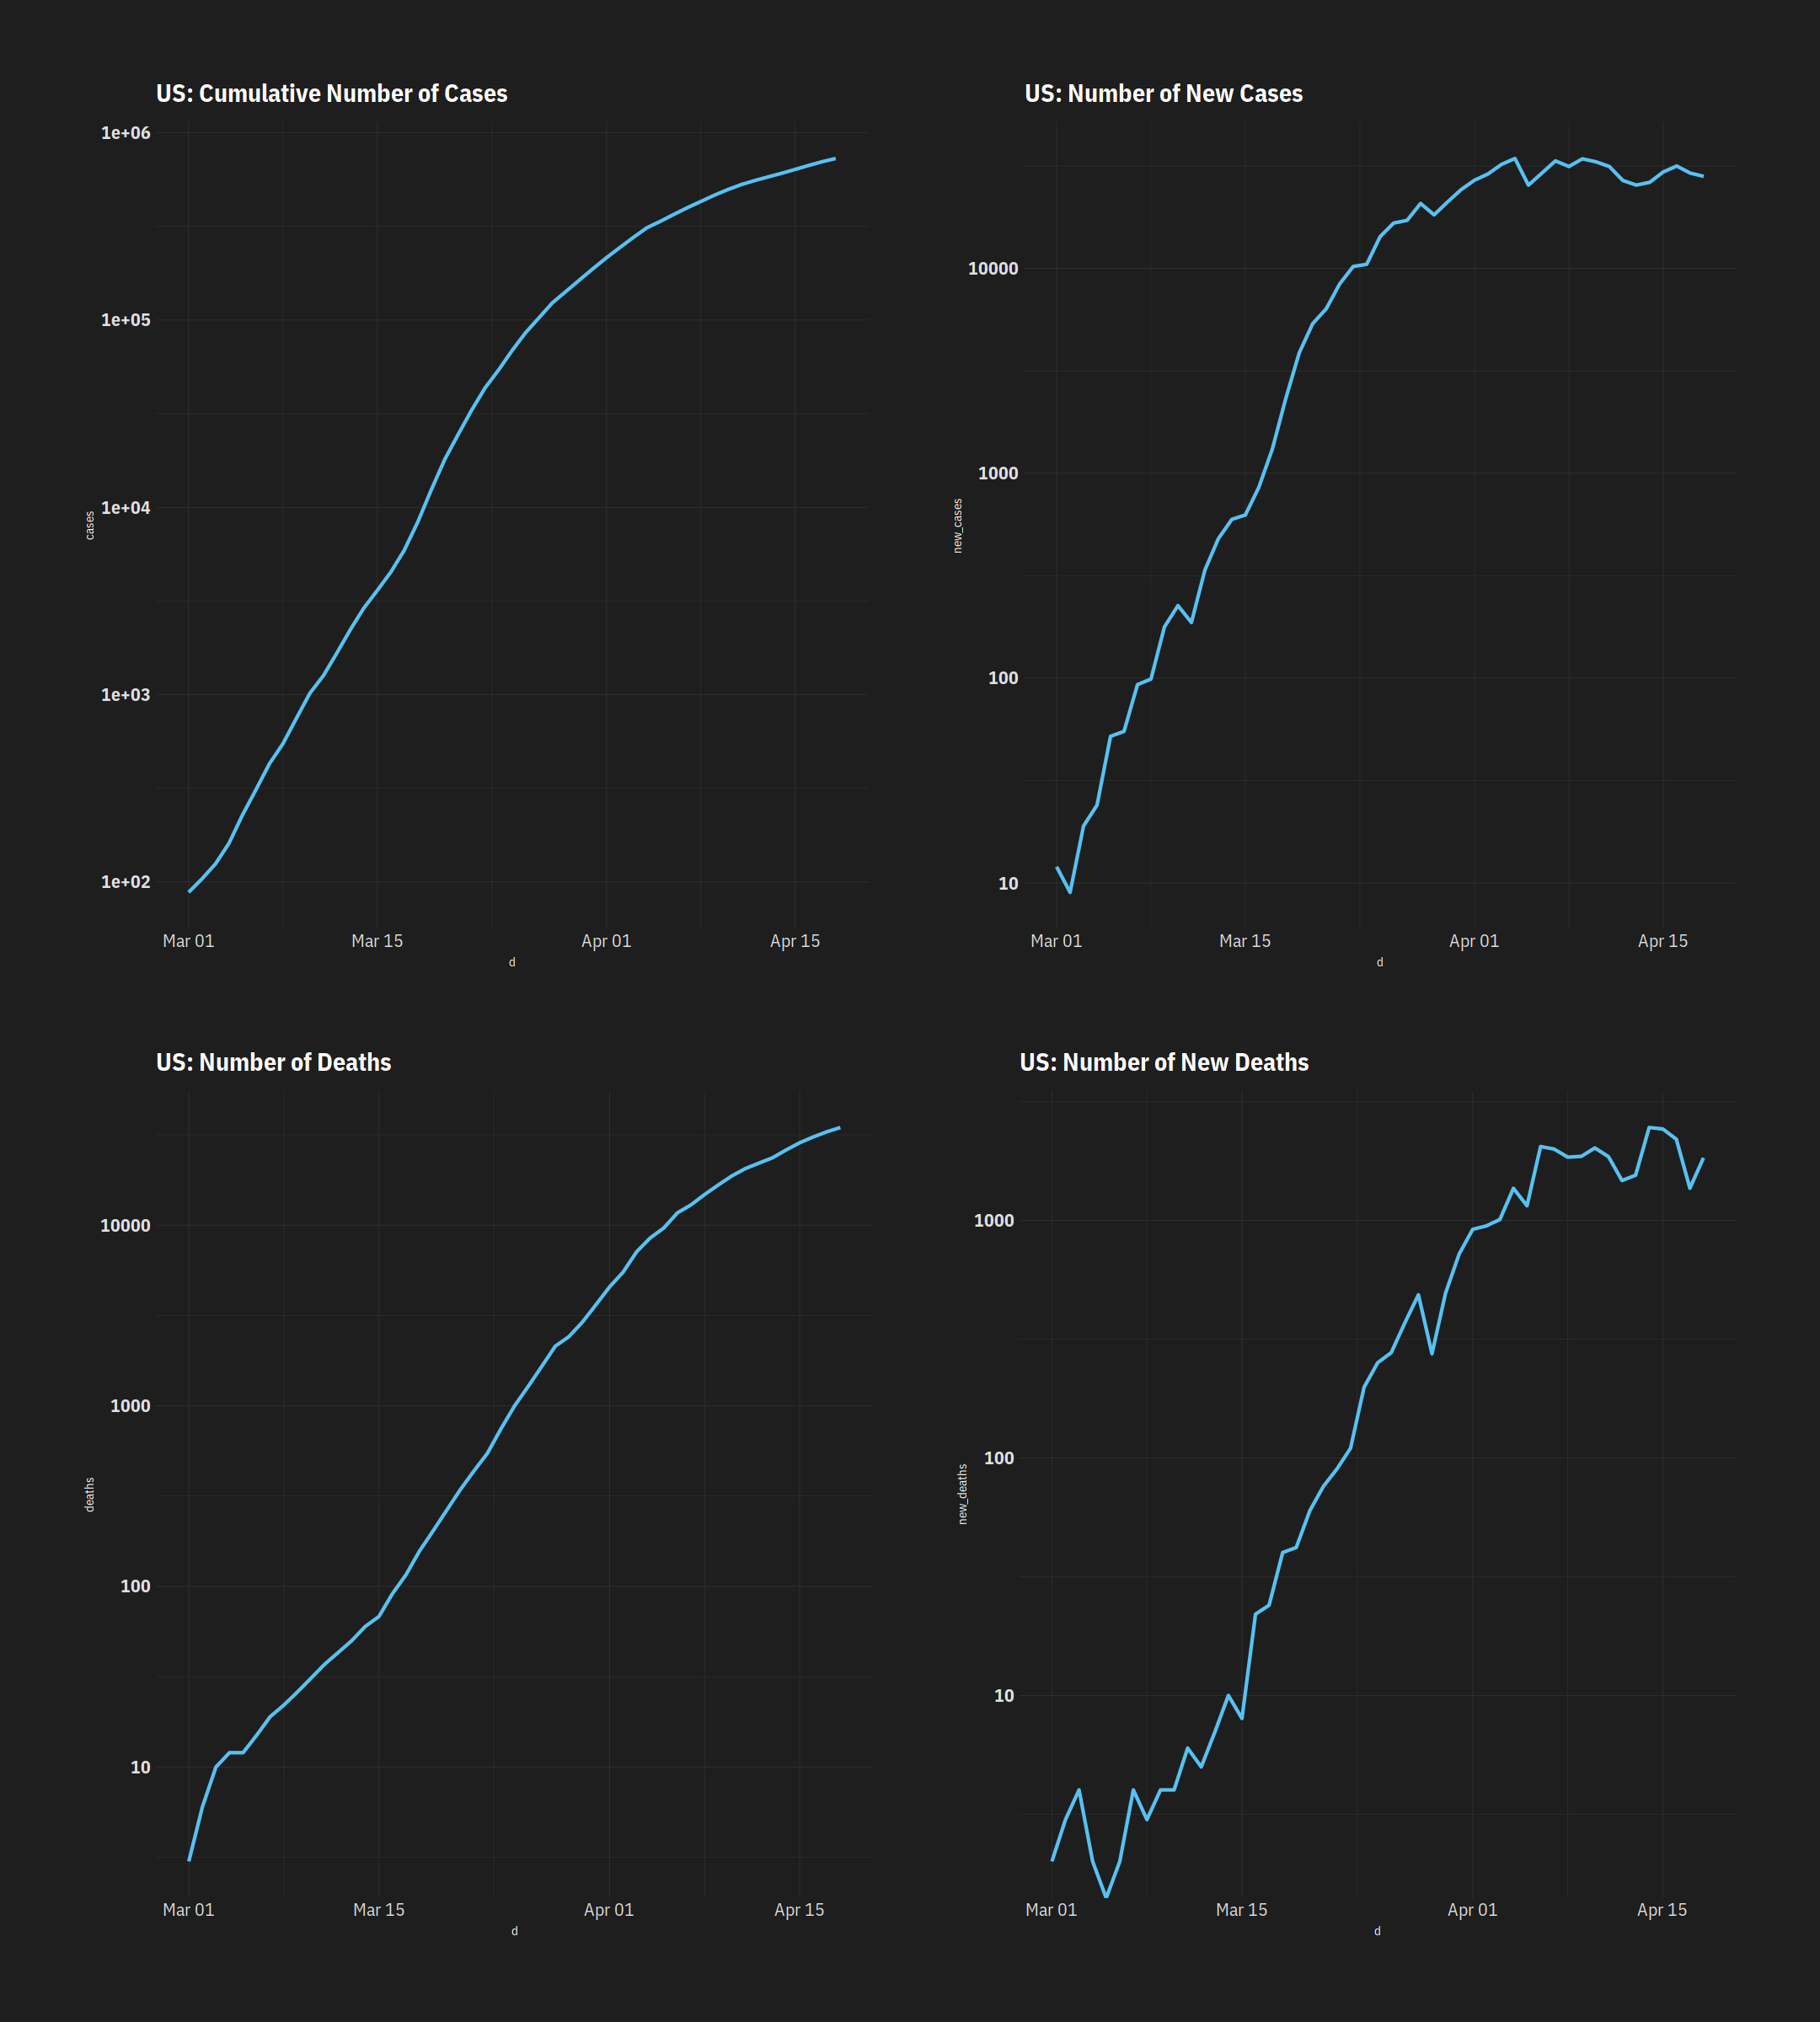

In [8]:
p1 = ggplot(npan, aes(x = d, y = cases)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("US: Cumulative Number of Cases")

p11 = ggplot(npan, aes(x = d, y = new_cases)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("US: Number of New Cases")

p2 = ggplot(npan, aes(x = d, y = deaths)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("US: Number of Deaths")

p22 = ggplot(npan, aes(x = d, y = new_deaths)) +
  geom_line(size = 1.2) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("US: Number of New Deaths")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

## State Panel 

In [9]:
stpan = df[, lapply(.SD, sum, na.rm = T), by = .(state, d), .SDcols = rawvars]
(t10 = stpan[d == max(d)][order(-cases)][1:10])
stpan = rollmeaneR(stpan, grouping = "state")

state         d          cases  deaths new_cases new_deaths
1  New York      2020-04-18 236763 13362  7121      540       
2  New Jersey    2020-04-18  81420  4070  2953      230       
3  Massachusetts 2020-04-18  36372  1560  1970      156       
4  Pennsylvania  2020-04-18  31742  1150  1621      123       
5  California    2020-04-18  30829  1146  1431       96       
6  Michigan      2020-04-18  30718  2307   763       80       
7  Illinois      2020-04-18  29160  1272  1584      130       
8  Florida       2020-04-18  25484   747   739       22       
9  Louisiana     2020-04-18  23580  1267   462       54       
10 Texas         2020-04-18  18927   487   794       26

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


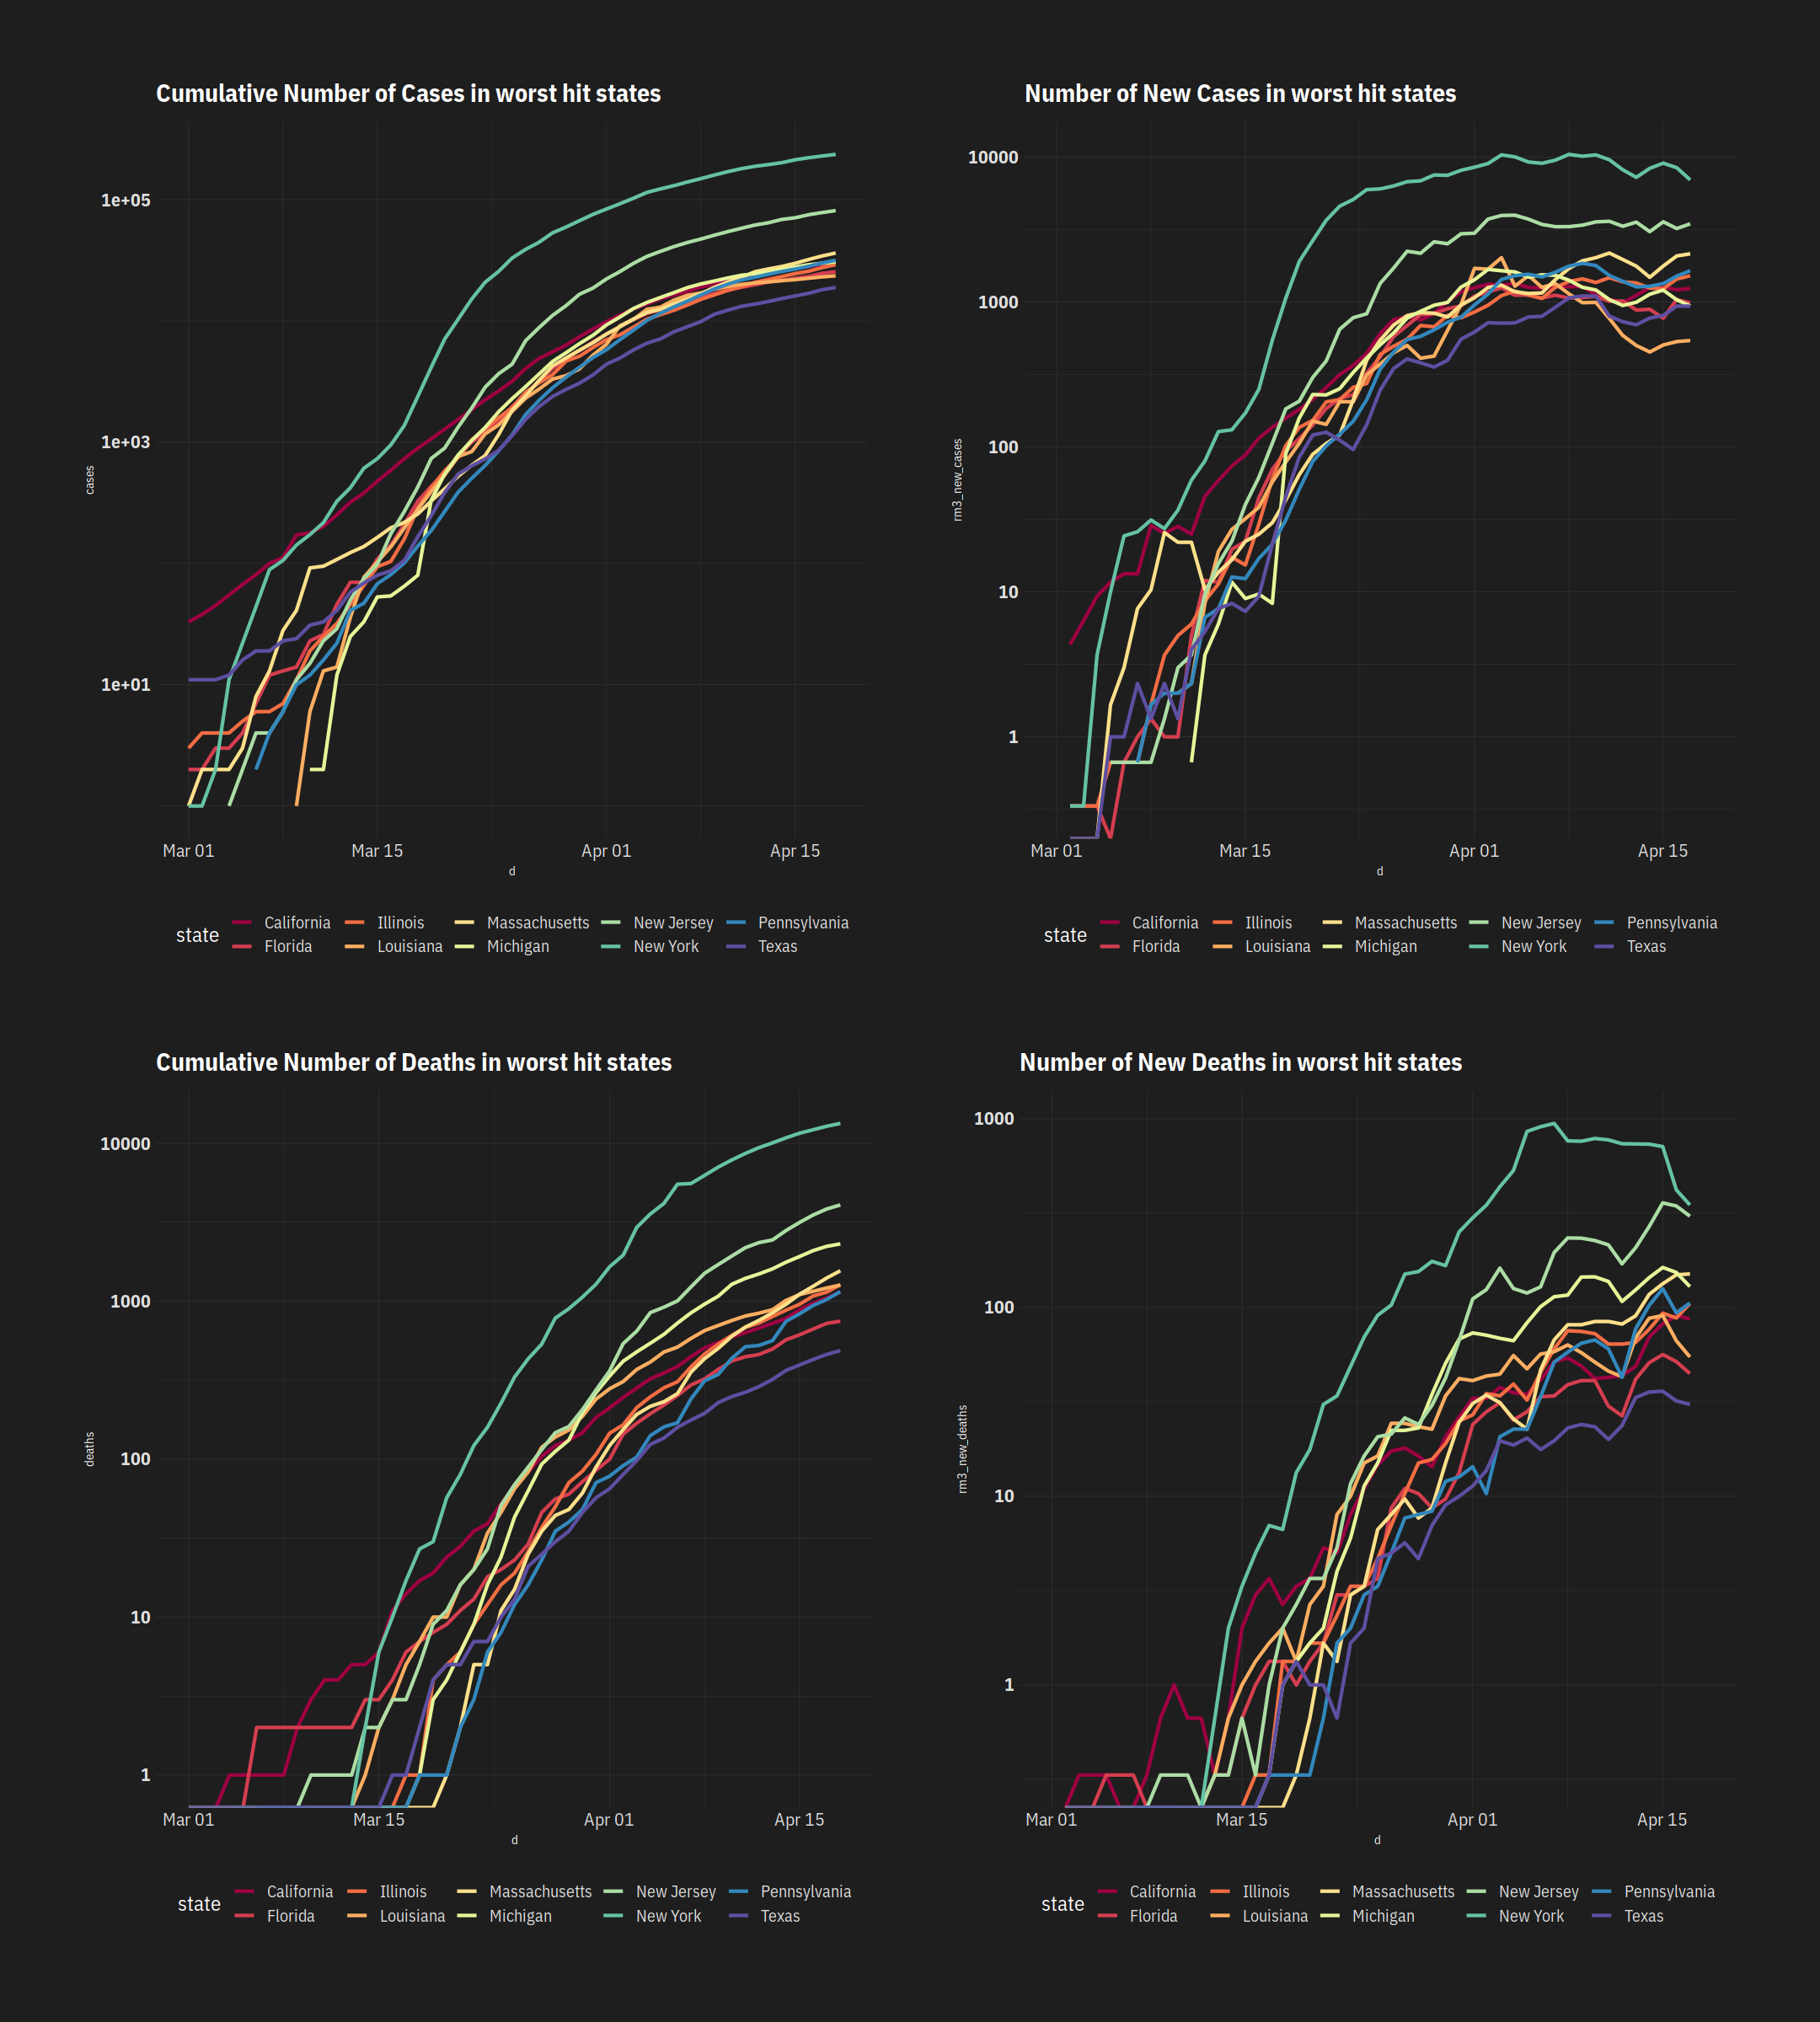

In [10]:
p1 = ggplot(stpan[state %in% t10$state], aes(x = d, y = cases, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Cases in worst hit states")

p11 = ggplot(stpan[state %in% t10$state], aes(x = d, y = rm3_new_cases, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Cases in worst hit states")

p2 = ggplot(stpan[state %in% t10$state], aes(x = d, y = deaths, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Deaths in worst hit states")

p22 = ggplot(stpan[state %in% t10$state], aes(x = d, y = rm3_new_deaths, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Deaths in worst hit states")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

## CA: Bay Area vs the rest

In [11]:
bay_counties = c(
  "San Francisco", "San Mateo", "Santa Clara",
  "Alameda", "Contra Costa", "Marin", 
  "Napa", "Solano", "Sonoma"
)

In [12]:
ca_all = df[state == "California"]
ca_all[, bayrea := case_when(
    county %in% bay_counties ~ "Bay",
    TRUE ~ "Elsewhere")]
vars = c("cases", "deaths", "new_cases", "new_deaths")
ca_div = ca_all[, lapply(.SD, sum, na.rm = T), 
   by = .(bayrea, d), .SDcols = vars]

ca_div %>% head

bayrea d          cases deaths new_cases new_deaths
1 Bay    2020-03-01 26    0      4         0         
2 Bay    2020-03-02 30    0      3         0         
3 Bay    2020-03-03 34    0      3         0         
4 Bay    2020-03-04 38    0      4         0         
5 Bay    2020-03-05 46    0      8         0         
6 Bay    2020-03-06 54    0      8         0

In [13]:
ca_div = rollmeaneR(ca_div, grouping = 'bayrea')

In [14]:
kvs = c("cases", "deaths", "new_cases", "new_deaths")
(cur = ca_div[order(-d), .SD[1], by = bayrea, .SDcols = kvs])
cur[, (deaths / cases)]
cur[, lapply(.SD, sum, na.rm = T), .SDcols = kvs]

bayrea    cases deaths new_cases new_deaths
1 Bay        6258 198     212       1        
2 Elsewhere 24571 948    1219      95

[1] 0.03164 0.03858

cases deaths new_cases new_deaths
1 30829 1146   1431      96

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


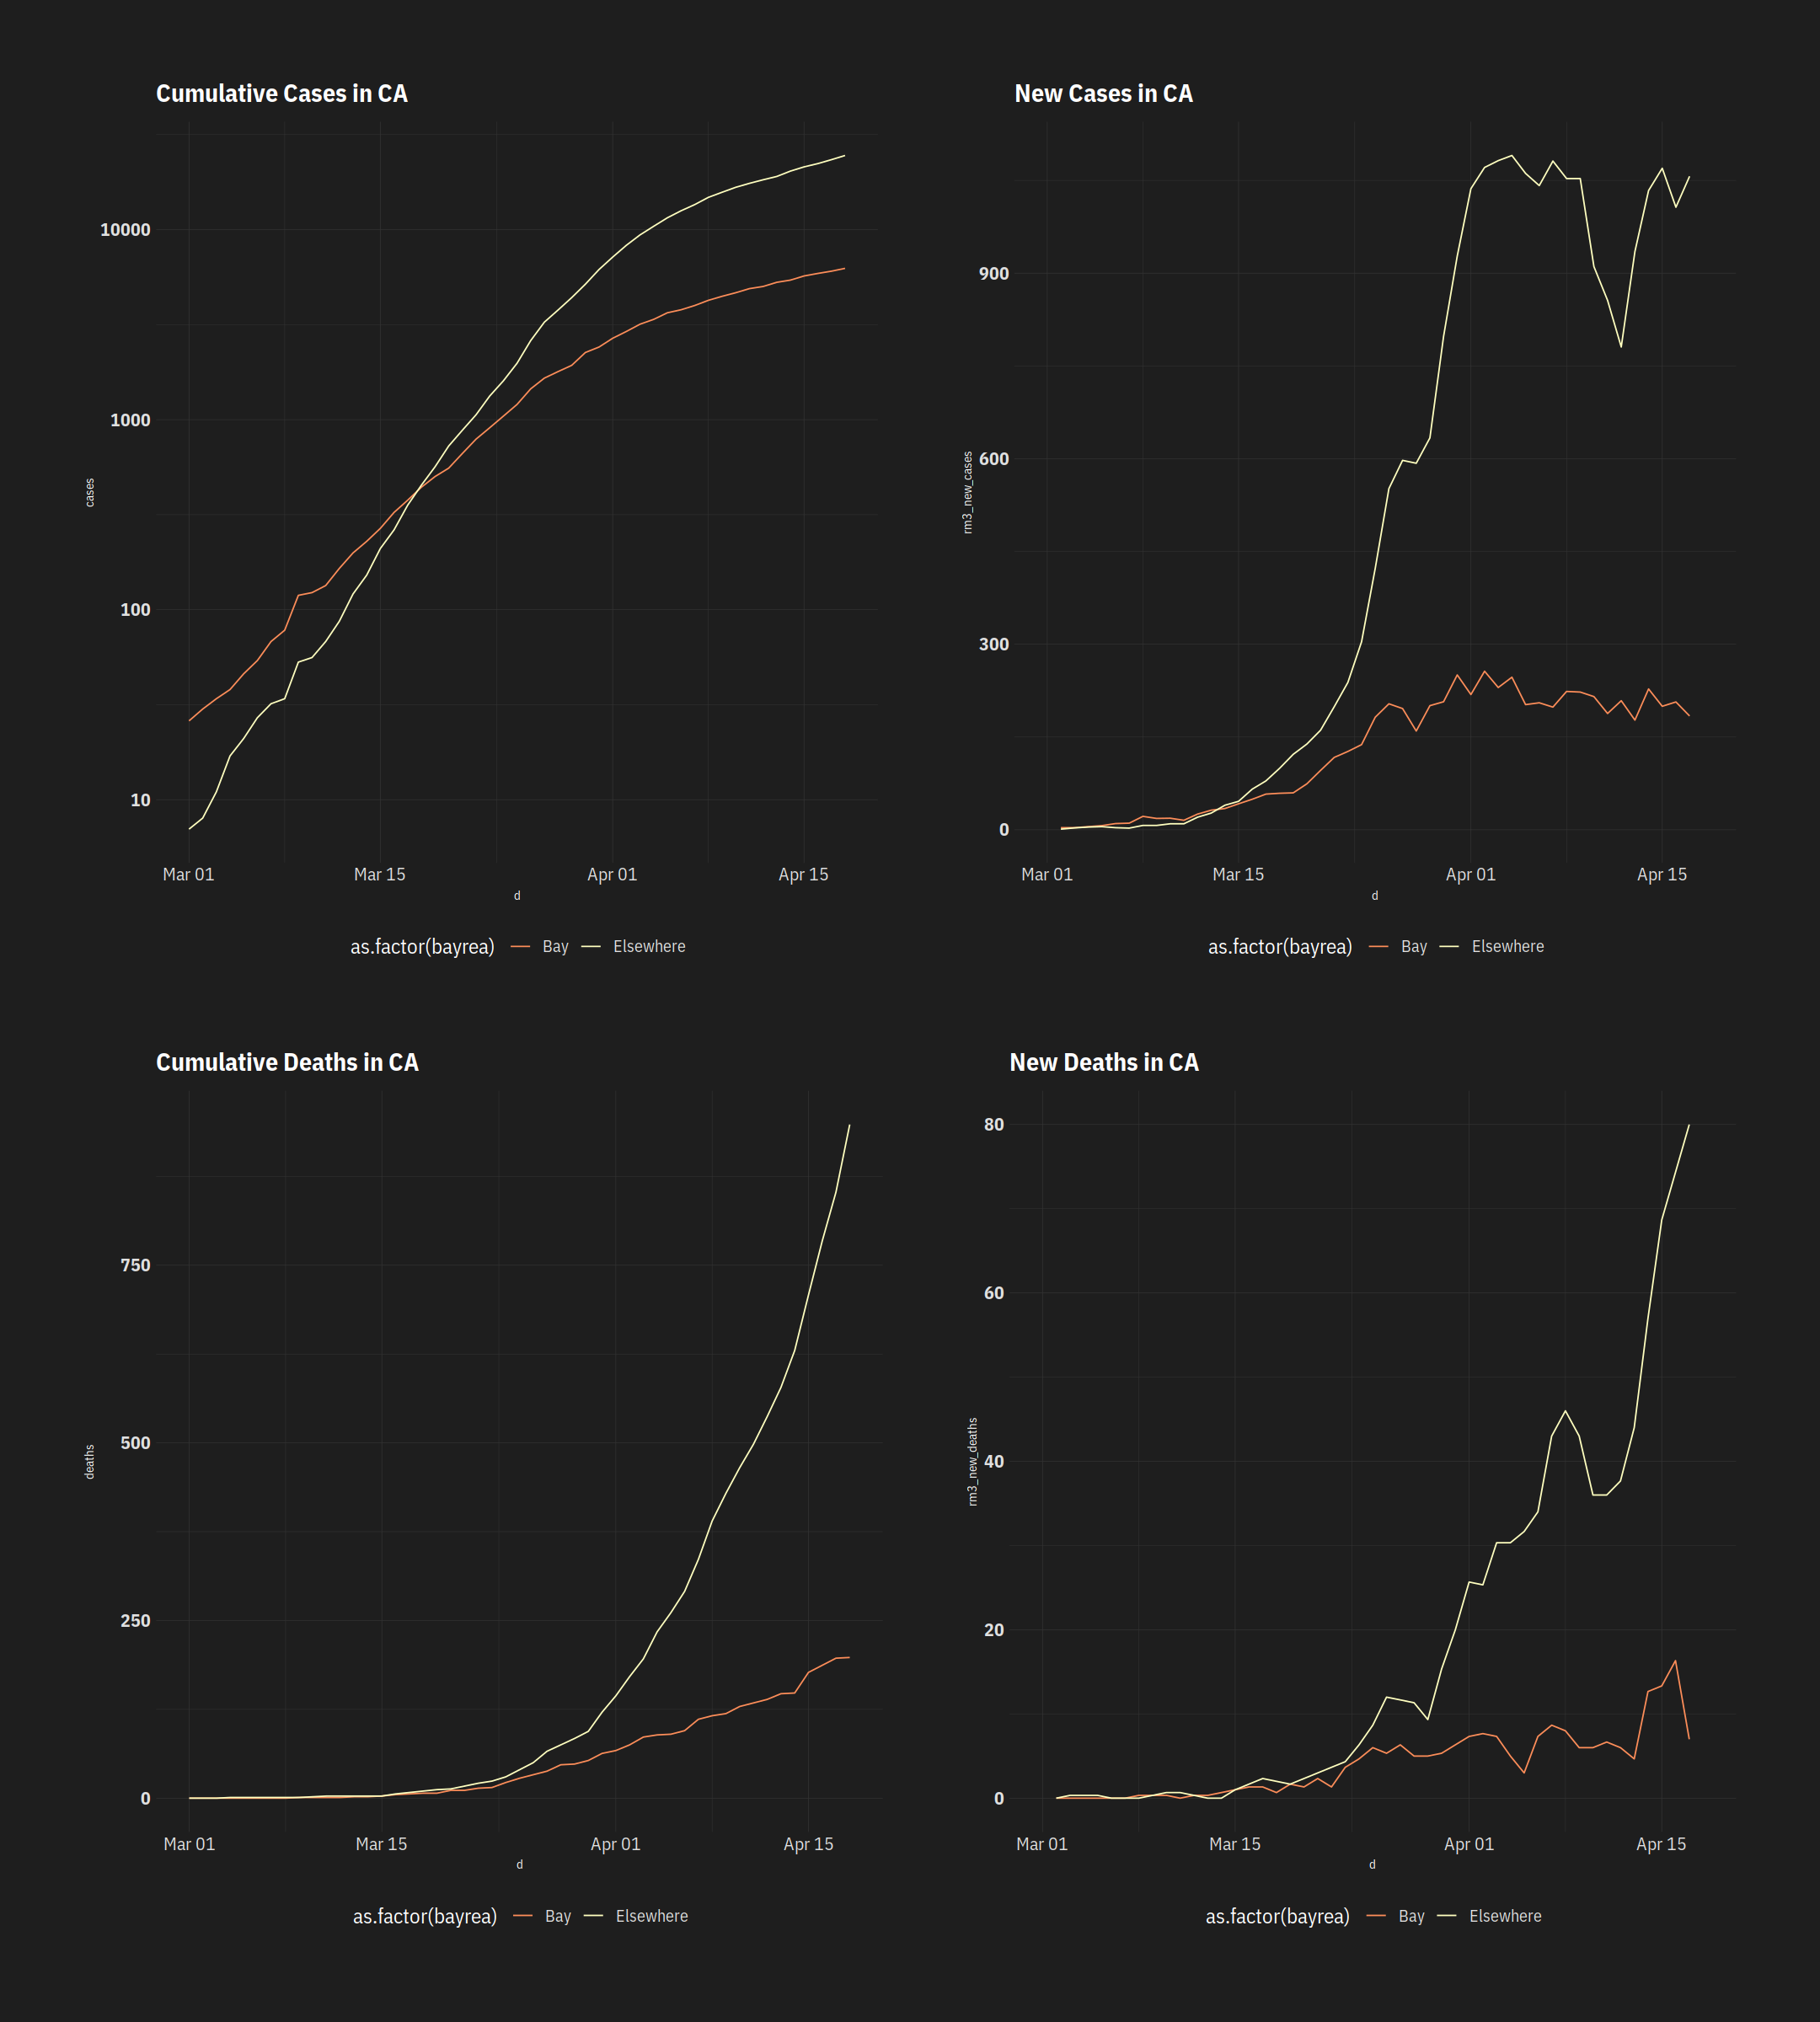

In [15]:
p1 = ggplot(ca_div, aes(x = d, y = cases, group = as.factor(bayrea), colour = as.factor(bayrea))) +
    geom_line() + scale_y_log10()+
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Cases in CA")
p2 = ggplot(ca_div, aes(x = d, y = rm3_new_cases, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line() +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Cases in CA")

p3 = ggplot(ca_div, aes(x = d, y = deaths, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line() +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Deaths in CA")

p4 = ggplot(ca_div, aes(x = d, y = rm3_new_deaths, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line() +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Deaths in CA")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p2) / (p3 | p4)

## Counties within the Bay Area

In [16]:
bayrea_mar = rollmeaneR(df[county %in% bay_counties & state == "California" & d>= "2020-03-01"])
bayrea_mar %>% glimpse

Rows: 438
Columns: 14
$ date           <chr> "2020-03-01", "2020-03-02", "2020-03-03", "2020-03-04"…
$ county         <chr> "Alameda", "Alameda", "Alameda", "Alameda", "Alameda",…
$ state          <chr> "California", "California", "California", "California"…
$ fips           <int> 6001, 6001, 6001, 6001, 6001, 6001, 6001, 6001, 6001, …
$ cases          <int> 1, 1, 2, 2, 2, 3, 3, 3, 24, 25, 25, 29, 29, 29, 37, 40…
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ d              <date> 2020-03-01, 2020-03-02, 2020-03-03, 2020-03-04, 2020-…
$ cfr            <dbl> 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.00…
$ new_cases      <int> NA, 0, 1, 0, 0, 1, 0, 0, 21, 1, 0, 4, 0, 0, 8, 3, 9, 4…
$ new_deaths     <int> NA, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ rm3_cases      <dbl> NA, 1.333, 1.667, 2.000, 2.333, 2.667, 3.000, 10.000, …
$ rm3_deaths     <dbl> NA, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.…
$ rm3_new_cases  <dbl> NA, NA,

### Cases

Warning message:
“Removed 21 row(s) containing missing values (geom_path).”


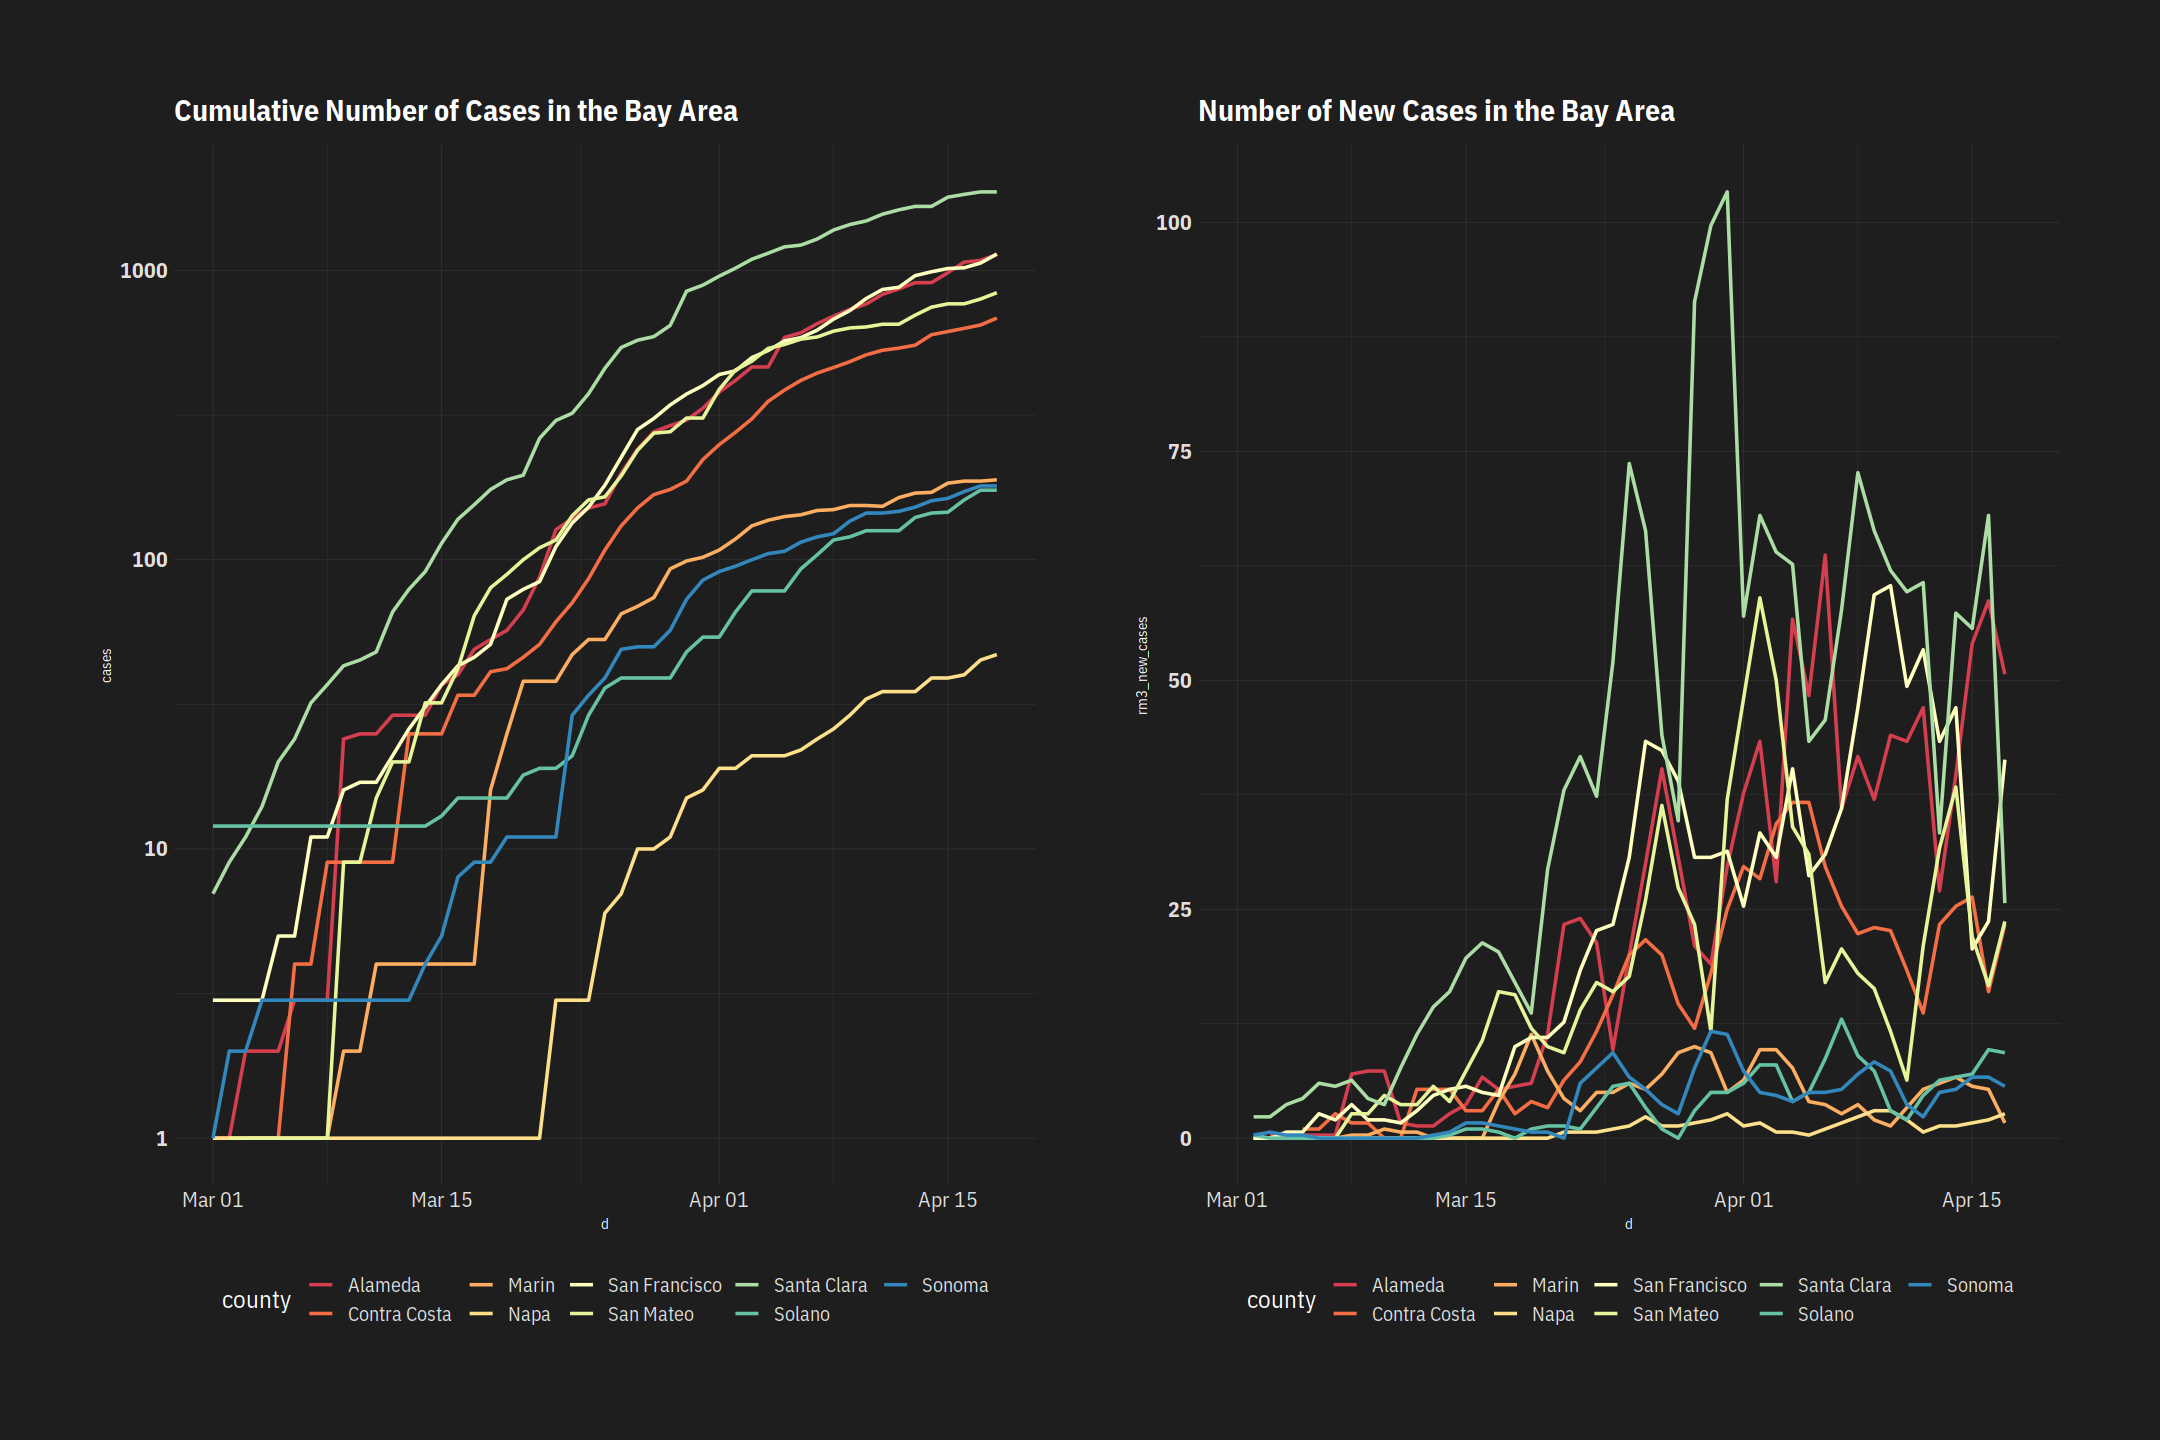

In [17]:
p1 = ggplot(bayrea_mar, aes(x = d, y = cases, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Cases in the Bay Area")

p2 = ggplot(bayrea_mar, aes(x = d, y = rm3_new_cases, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Cases in the Bay Area")
options(repr.plot.width = 18, repr.plot.height=12)
(p1 | p2)

In [18]:
embed_notebook(ggplotly(p2))

Warning message:
“`group_by_()` is deprecated as of dplyr 0.7.0.
Please use `group_by()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgo8aGVhZD4KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+Cjx0aXRsZT5wbG90bHk8L3RpdGxlPgo8c2NyaXB0PihmdW5jdGlvbigpIHsKICAvLyBJZiB3aW5kb3cuSFRNTFdpZGdldHMgaXMgYWxyZWFkeSBkZWZpbmVkLCB0aGVuIHVzZSBpdDsgb3RoZXJ3aXNlIGNyZWF0ZSBhCiAgLy8gbmV3IG9iamVjdC4gVGhpcyBhbGxvd3MgcHJlY2VkaW5nIGNvZGUgdG8gc2V0IG9wdGlvbnMgdGhhdCBhZmZlY3QgdGhlCiAgLy8gaW5pdGlhbGl6YXRpb24gcHJvY2VzcyAodGhvdWdoIG5vbmUgY3VycmVudGx5IGV4aXN0KS4KICB3aW5kb3cuSFRNTFdpZGdldHMgPSB3aW5kb3cuSFRNTFdpZGdldHMgfHwge307CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIGEgdmlld2VyIHBhbmUuIElmIG5vdCwgd2UncmUgaW4gYSB3ZWIgYnJvd3Nlci4KICB2YXIgdmlld2VyTW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy52aWV3ZXJNb2RlID0KICAgICAgL1xidmlld2VyX3BhbmU9MVxiLy50ZXN0KHdpbmRvdy5sb2NhdGlvbik7CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIFNoaW55IG1vZGUuIElmIG5vdCwgaXQncyBhIHN0YXRpYyBkb2N1bWVudC4KICAvLyBOb3RlIHRoYXQgc3RhdGljIHdpZGdldHMgY2FuIGFwcGVhciBpbiBib3RoIFNoaW55IGFuZCBzdGF0aWMgbW9kZXMsIGJ1dAogIC8vIG9idmlvdXNseSwgU2hpbnkgd2lkZ2V0cyBjYW4gb25seSBhcHBlYXIgaW4gU2hpbnkgYXBwcy9kb2N1bWVudHMuCiAgdmFyIHNoaW55TW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy5zaGlueU1vZGUgPQogICAgICB0eXBlb2Yod2luZG93LlNoaW55KSAhPT0gInVuZGVmaW5lZCIgJiYgISF3aW5kb3cuU2hpbnkub3V0cHV0QmluZGluZ3M7CgogIC8vIFdlIGNhbid0IGNvdW50IG9uIGpRdWVyeSBiZWluZyBhdmFpbGFibGUsIHNvIHdlIGltcGxlbWVudCBvdXIgb3duCiAgLy8gdmVyc2lvbiBpZiBuZWNlc3NhcnkuCiAgZnVuY3Rpb24gcXVlcnlTZWxlY3RvckFsbChzY29wZSwgc2VsZWN0b3IpIHsKICAgIGlmICh0eXBlb2YoalF1ZXJ5KSAhPT0gInVuZGVmaW5lZCIgJiYgc2NvcGUgaW5zdGFuY2VvZiBqUXVlcnkpIHsKICAgICAgcmV0dXJuIHNjb3BlLmZpbmQoc2VsZWN0b3IpOwogICAgfQogICAgaWYgKHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwpIHsKICAgICAgcmV0dXJuIHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwoc2VsZWN0b3IpOwogICAgfQogIH0KCiAgZnVuY3Rpb24gYXNBcnJheSh2YWx1ZSkgewogICAgaWYgKHZhbHVlID09PSBudWxsKQogICAgICByZXR1cm4gW107CiAgICBpZiAoJC5pc0FycmF5KHZhbHVlKSkKICAgICAgcmV0dXJuIHZhbHVlOwogICAgcmV0dXJuIFt2YWx1ZV07CiAgfQoKICAvLyBJbXBsZW1lbnQgalF1ZXJ5J3MgZXh0ZW5kCiAgZnVuY3Rpb24gZXh0ZW5kKHRhcmdldCAvKiwgLi4uICovKSB7CiAgICBpZiAoYXJndW1lbnRzLmxlbmd0aCA9PSAxKSB7CiAgICAgIHJldHVybiB0YXJnZXQ7CiAgICB9CiAgICBmb3IgKHZhciBpID0gMTsgaSA8IGFyZ3VtZW50cy5sZW5ndGg7IGkrKykgewogICAgICB2YXIgc291cmNlID0gYXJndW1lbnRzW2ldOwogICAgICBmb3IgKHZhciBwcm9wIGluIHNvdXJjZSkgewogICAgICAgIGlmIChzb3VyY2UuaGFzT3duUHJvcGVydHkocHJvcCkpIHsKICAgICAgICAgIHRhcmdldFtwcm9wXSA9IHNvdXJjZVtwcm9wXTsKICAgICAgICB9CiAgICAgIH0KICAgIH0KICAgIHJldHVybiB0YXJnZXQ7CiAgfQoKICAvLyBJRTggZG9lc24ndCBzdXBwb3J0IEFycmF5LmZvckVhY2guCiAgZnVuY3Rpb24gZm9yRWFjaCh2YWx1ZXMsIGNhbGxiYWNrLCB0aGlzQXJnKSB7CiAgICBpZiAodmFsdWVzLmZvckVhY2gpIHsKICAgICAgdmFsdWVzLmZvckVhY2goY2FsbGJhY2ssIHRoaXNBcmcpOwogICAgfSBlbHNlIHsKICAgICAgZm9yICh2YXIgaSA9IDA7IGkgPCB2YWx1ZXMubGVuZ3RoOyBpKyspIHsKICAgICAgICBjYWxsYmFjay5jYWxsKHRoaXNBcmcsIHZhbHVlc1tpXSwgaSwgdmFsdWVzKTsKICAgICAgfQogICAgfQogIH0KCiAgLy8gUmVwbGFjZXMgdGhlIHNwZWNpZmllZCBtZXRob2Qgd2l0aCB0aGUgcmV0dXJuIHZhbHVlIG9mIGZ1bmNTb3VyY2UuCiAgLy8KICAvLyBOb3RlIHRoYXQgZnVuY1NvdXJjZSBzaG91bGQgbm90IEJFIHRoZSBuZXcgbWV0aG9kLCBpdCBzaG91bGQgYmUgYSBmdW5jdGlvbgogIC8vIHRoYXQgUkVUVVJOUyB0aGUgbmV3IG1ldGhvZC4gZnVuY1NvdXJjZSByZWNlaXZlcyBhIHNpbmdsZSBhcmd1bWVudCB0aGF0IGlzCiAgLy8gdGhlIG92ZXJyaWRkZW4gbWV0aG9kLCBpdCBjYW4gYmUgY2FsbGVkIGZyb20gdGhlIG5ldyBtZXRob2QuIFRoZSBvdmVycmlkZGVuCiAgLy8gbWV0aG9kIGNhbiBiZSBjYWxsZWQgbGlrZSBhIHJlZ3VsYXIgZnVuY3Rpb24sIGl0IGhhcyB0aGUgdGFyZ2V0IHBlcm1hbmVudGx5CiAgLy8gYm91bmQgdG8gaXQgc28gInRoaXMiIHdpbGwgd29yayBjb3JyZWN0bHkuCiAgZnVuY3Rpb24gb3ZlcnJpZGVNZXRob2QodGFyZ2V0LCBtZXRob2ROYW1lLCBmdW5jU291cmNlKSB7CiAgICB2YXIgc3VwZXJGdW5jID0gdGFyZ2V0W21ldGhvZE5hbWVdIHx8IGZ1bmN0aW9uKCkge307CiAgICB2YXIgc3VwZXJGdW5jQm91bmQgPSBmdW5jdGlvbigpIHsKICAgICAgcmV0dXJuIHN1cGVyRnVuYy5hcHBseSh0YXJnZXQsIGFyZ3VtZW50cyk7CiAgICB9OwogICAgdGFyZ2V0W21ldGhvZE5hbWVdID0gZnVuY1NvdXJjZShzdXBlckZ1bmNCb3VuZCk7CiAgfQoKICAvLyBBZGQgYSBtZXRob2QgdG8gZGVsZWdhdG9yIHRoYXQsIHdoZW4gaW52b2tlZCwgY2FsbHMKICAvLyBkZWxlZ2F0ZWUubWV0aG9kTmFtZS4gSWYgdGhlcmUgaXMgbm8gc3VjaCBtZXRob2Qgb24KICAvLyB0aGUgZGVsZWdhdGVlLCBidXQgdGhlcmUgd2FzIG9uZSBvbiBkZWxlZ2F0b3IgYmVmb3JlCiAgLy8gZGVsZWdhdGVNZXRob2Qgd2FzIGNhbGxlZCwgdGhlbiB

### Deaths

Warning message:
“Removed 21 row(s) containing missing values (geom_path).”


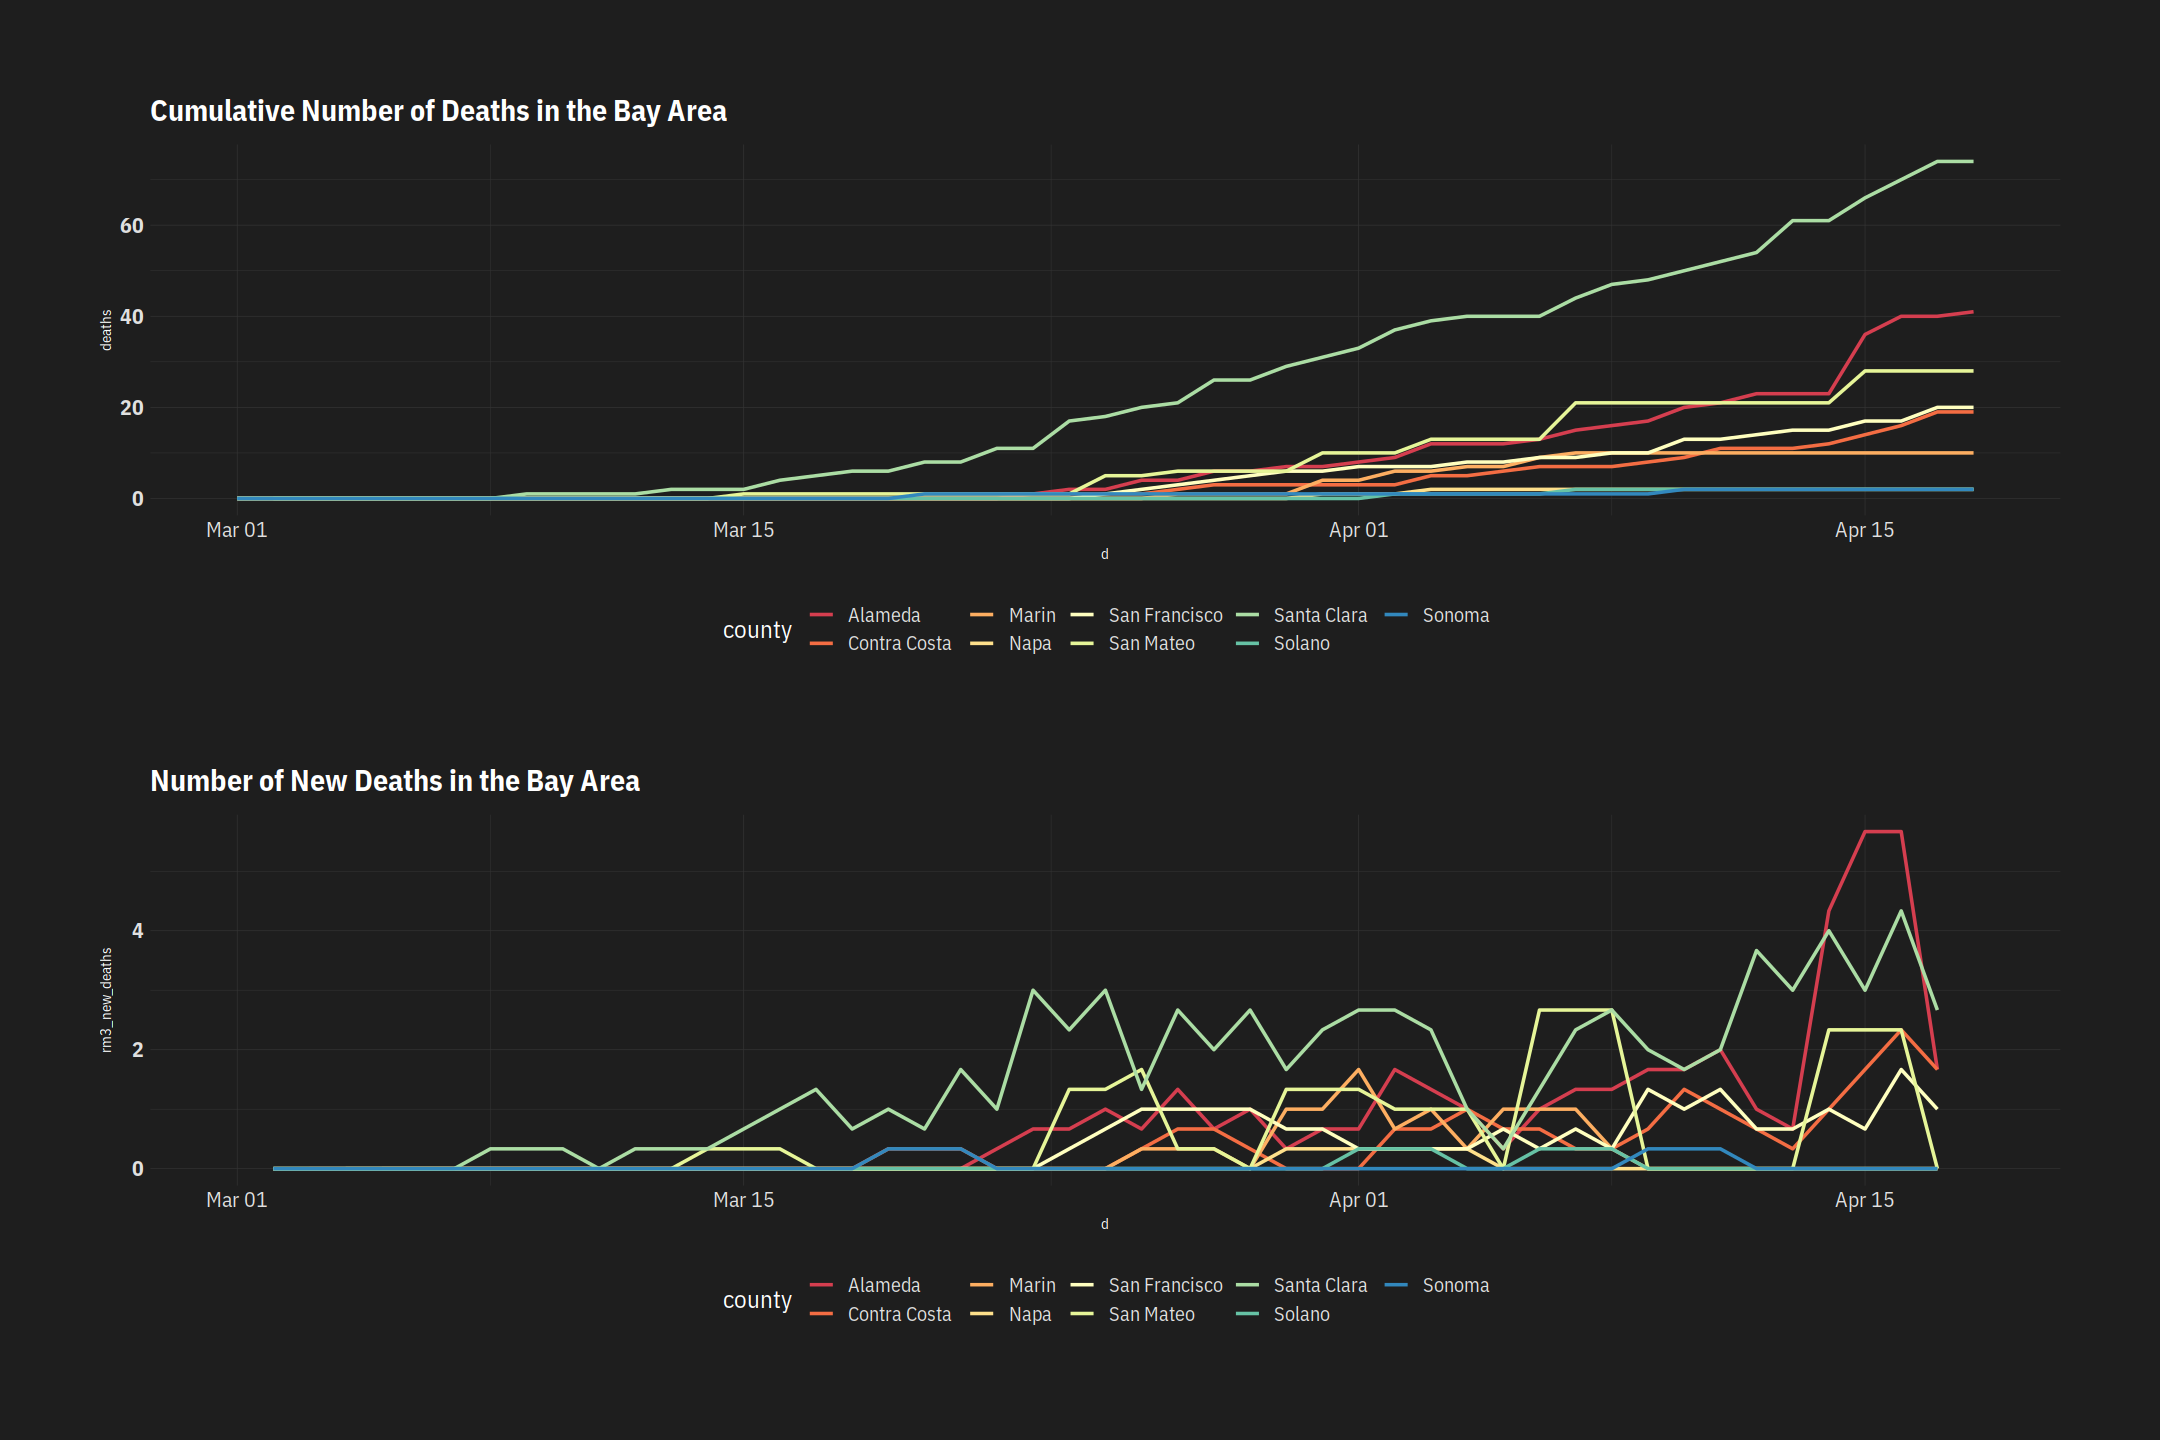

In [19]:
p1 = ggplot(bayrea_mar, aes(x = d, y = deaths, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Deaths in the Bay Area")
p2 = ggplot(bayrea_mar, aes(x = d, y = rm3_new_deaths, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Deaths in the Bay Area")
(p1 / p2)

In [ ]:
embed_notebook(ggplotly(p2))